# Proyek Klasifikasi Gambar: [Garbage Classification]
- **Nama:** Ulfa Stevi Juliana
- **Email:** steviulpa@gmail.com
- **ID Dicoding:** ulfasj

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ulfastevijuliana","key":"78e9a3fd29a791eb9e12e692ccace2f0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!ls ~/.kaggle

kaggle.json


In [5]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mostafaabla/garbage-classification
!unzip garbage-classification.zip -d garbage_data

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: garbage_data/garbage_classification/paper/paper381.jpg  
  inflating: garbage_data/garbage_classification/paper/paper382.jpg  
  inflating: garbage_data/garbage_classification/paper/paper383.jpg  
  inflating: garbage_data/garbage_classification/paper/paper384.jpg  
  inflating: garbage_data/garbage_classification/paper/paper385.jpg  
  inflating: garbage_data/garbage_classification/paper/paper386.jpg  
  inflating: garbage_data/garbage_classification/paper/paper387.jpg  
  inflating: garbage_data/garbage_classification/paper/paper388.jpg  
  inflating: garbage_data/garbage_classification/paper/paper389.jpg  
  inflating: garbage_data/garbage_classification/paper/paper39.jpg  
  inflating: garbage_data/garbage_classification/paper/paper390.jpg  
  inflating: garbage_data/garbage_classification/paper/paper391.jpg  
  inflating: garbage_data/garbage_classification/paper/paper392.jpg  
  inflating: garbage_data/garbag

In [6]:
!ls garbage_data


garbage_classification


In [7]:
source_dir = 'garbage_data/garbage_classification'

In [8]:
print("Isi folder source_dir:")
print(os.listdir(source_dir))

Isi folder source_dir:
['battery', 'white-glass', 'cardboard', 'biological', 'brown-glass', 'green-glass', 'trash', 'clothes', 'shoes', 'metal', 'plastic', 'paper']


### Data Preprocessing

In [9]:
root_path = "garbage_data"

for root, dirs, files in os.walk(root_path):
    level = root.replace(root_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # tampilkan 5 file pertama tiap folder
        print(f"{subindent}{f}")

garbage_data/
    garbage_classification/
        battery/
            battery125.jpg
            battery275.jpg
            battery476.jpg
            battery364.jpg
            battery670.jpg
        white-glass/
            white-glass176.jpg
            white-glass98.jpg
            white-glass644.jpg
            white-glass188.jpg
            white-glass603.jpg
        cardboard/
            cardboard555.jpg
            cardboard220.jpg
            cardboard772.jpg
            cardboard52.jpg
            cardboard755.jpg
        biological/
            biological575.jpg
            biological909.jpg
            biological771.jpg
            biological879.jpg
            biological486.jpg
        brown-glass/
            brown-glass537.jpg
            brown-glass192.jpg
            brown-glass97.jpg
            brown-glass31.jpg
            brown-glass386.jpg
        green-glass/
            green-glass612.jpg
            green-glass583.jpg
            green-glass346.jpg
          

In [10]:
import random

source_dir = 'garbage_data/garbage_classification'
target_dir = 'sorted_data'

category_mapping = {
    "battery": "non-recyclable",
    "biological": "non-recyclable",
    "trash": "non-recyclable",
    "brown-glass": "glass-material",
    "green-glass": "glass-material",
    "white-glass": "glass-material",
    "cardboard": "paper-material",
    "paper": "paper-material",
    "clothes": "fabric-product",
    "shoes": "fabric-product",
    "metal": "recyclable-inorganic",
    "plastic": "recyclable-inorganic"
}
# Buat folder target dan subfolder kategori
for new_cat in set(category_mapping.values()):
    os.makedirs(os.path.join(target_dir, new_cat), exist_ok=True)

# Counter nama file unik
file_counters = {key: 1 for key in category_mapping.values()}

# Proses tiap kategori lama
for old_cat, new_cat in category_mapping.items():
    src_path = os.path.join(source_dir, old_cat)
    dst_path = os.path.join(target_dir, new_cat)

    if not os.path.exists(src_path):
        print(f"Folder is not found: {src_path}")
        continue

    files = os.listdir(src_path)

    # Downsampling clothes
    if old_cat == "clothes" and len(files) > 2000:
        files = random.sample(files, 2000)

    for f in files:
        full_src = os.path.join(src_path, f)
        if os.path.isfile(full_src):
            new_filename = f"{new_cat}_{file_counters[new_cat]}.jpg"
            full_dst = os.path.join(dst_path, new_filename)
            shutil.copy2(full_src, full_dst)
            file_counters[new_cat] += 1

    print(f"{old_cat} → {new_cat}: {file_counters[new_cat]-1} file")

# Tampilkan jumlah file per kategori
print("\nJumlah file per kategori baru:")
total = 0
for cat in os.listdir(target_dir):
    path = os.path.join(target_dir, cat)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
    print(f"{cat}: {count}")
    total += count
print(f"Total: {total}")


battery → non-recyclable: 945 file
biological → non-recyclable: 1930 file
trash → non-recyclable: 2627 file
brown-glass → glass-material: 607 file
green-glass → glass-material: 1236 file
white-glass → glass-material: 2011 file
cardboard → paper-material: 891 file
paper → paper-material: 1941 file
clothes → fabric-product: 2000 file
shoes → fabric-product: 3977 file
metal → recyclable-inorganic: 769 file
plastic → recyclable-inorganic: 1634 file

Jumlah file per kategori baru:
non-recyclable: 2627
paper-material: 1941
fabric-product: 3977
glass-material: 2011
recyclable-inorganic: 1634
Total: 12190


In [11]:
def print_images_resolution(directory, max_images_per_class=10):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        sampled_files = image_files[:max_images_per_class]
        num_images = len(sampled_files)

        print(f"{subdir}: {num_images}")
        total_images += num_images

        unique_sizes = set()
        for img_file in sampled_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

In [12]:
print_images_resolution(target_dir, max_images_per_class=5)

non-recyclable: 5
- (225, 225)
- (275, 183)
- (287, 176)
- (183, 275)
- (304, 166)
---------------
paper-material: 5
- (190, 266)
- (318, 159)
- (186, 271)
- (512, 384)
---------------
fabric-product: 5
- (400, 534)
- (300, 168)
- (400, 533)
---------------
glass-material: 5
- (225, 225)
- (183, 275)
- (512, 384)
- (259, 194)
---------------
recyclable-inorganic: 5
- (266, 189)
- (275, 183)
- (512, 384)
- (259, 195)
---------------


In [13]:
#check labels
pd.DataFrame(os.listdir(target_dir),columns=['Folder_Name'])

,Folder_Name
0,non-recyclable
1,paper-material
2,fabric-product
3,glass-material
4,recyclable-inorganic


In [14]:
import glob
files = [i for i in glob.glob(target_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,sorted_data/recyclable-inorganic/recyclable-in...,recyclable-inorganic
1,sorted_data/non-recyclable/non-recyclable_40.jpg,non-recyclable
2,sorted_data/non-recyclable/non-recyclable_979.jpg,non-recyclable
3,sorted_data/glass-material/glass-material_1431...,glass-material
4,sorted_data/fabric-product/fabric-product_3157...,fabric-product
...,...,...
12185,sorted_data/non-recyclable/non-recyclable_1020...,non-recyclable
12186,sorted_data/glass-material/glass-material_1177...,glass-material
12187,sorted_data/recyclable-inorganic/recyclable-in...,recyclable-inorganic
12188,sorted_data/non-recyclable/non-recyclable_1751...,non-recyclable


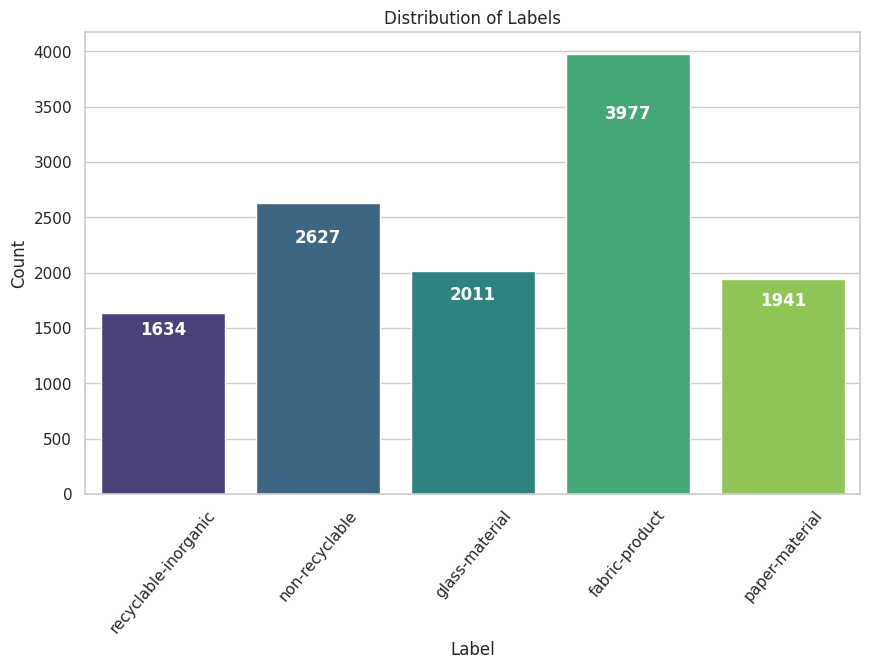

In [15]:
#visualisasi distribusi data
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = dataframe["Label"].value_counts()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x=dataframe["Label"], palette="viridis")

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()/1.2),
                ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points', fontsize=12, fontweight='bold', color='white')

plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=50)
plt.show()


In [16]:
def show_one_image_per_class(directory):
    classes = [cls for cls in os.listdir(directory) if os.path.isdir(os.path.join(directory, cls))]
    num_classes = len(classes)
    cols = 2
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(20, rows * 5))

    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            continue
        img_file = random.choice(image_files)

        img_path = os.path.join(class_path, img_file)
        with Image.open(img_path) as img:
            ax = plt.subplot(rows, cols, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(cls, fontsize=14)

    plt.tight_layout()
    plt.show()

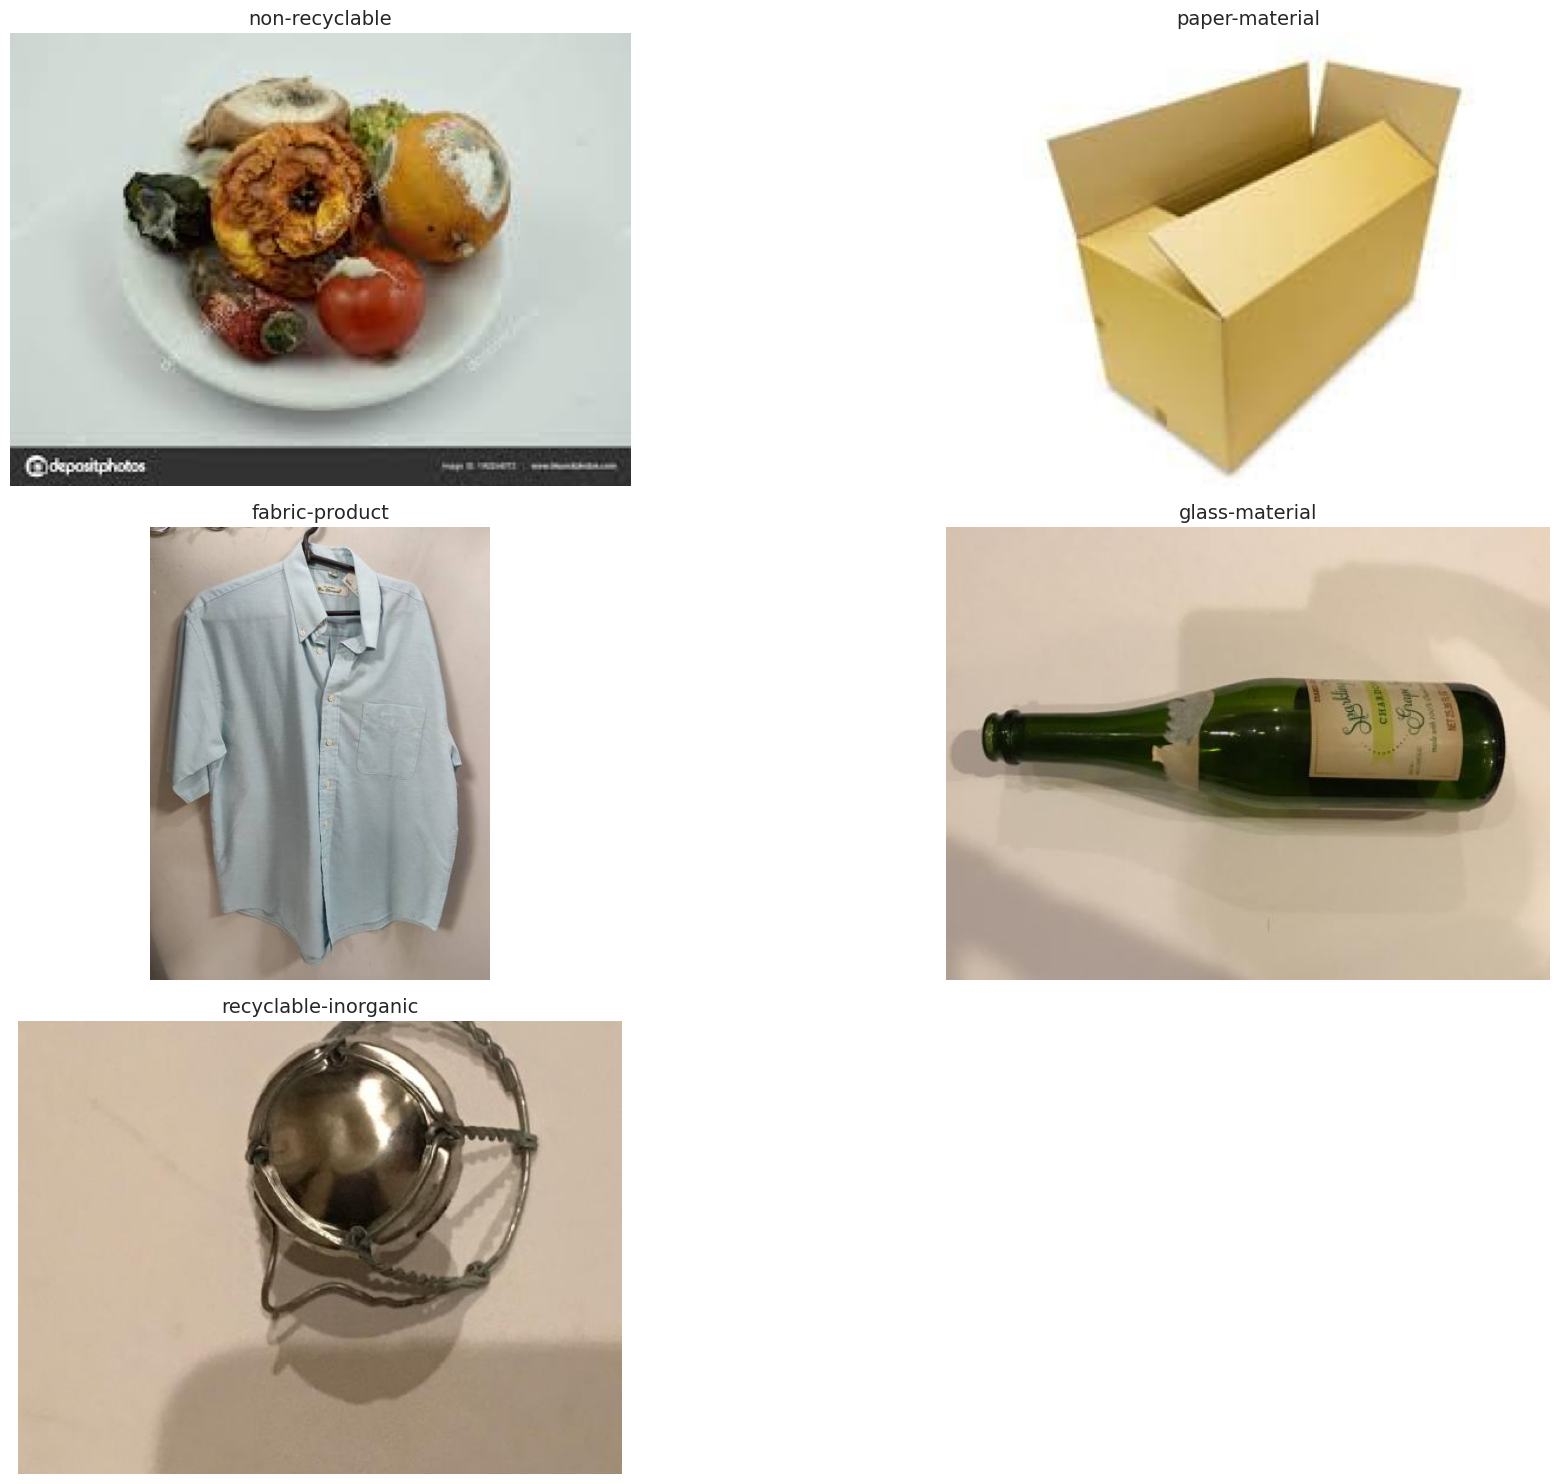

In [17]:
show_one_image_per_class(target_dir)

#### Split Dataset

In [18]:
mainPath = target_dir
new_dataPath = mainPath

train_dir = "Dataset/train"
val_dir = "Dataset/val"
test_dir = "Dataset/test"

BATCH_SIZE = 64
TARGET_SIZE = (299, 299)

In [19]:
classes = os.listdir(target_dir)
class_indices = {name: index for index, name in enumerate(classes)}

print("Class indices:", class_indices)

Class indices: {'non-recyclable': 0, 'paper-material': 1, 'fabric-product': 2, 'glass-material': 3, 'recyclable-inorganic': 4}


In [20]:
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)
    for cls in classes:
        os.makedirs(os.path.join(directory, cls), exist_ok=True)

random.seed(42)

#fungsi untuk mrmbgi data secara seimbang
def safe_train_test_split(images, test_size, stratify_labels=None):
    if stratify_labels is not None and len(set(stratify_labels)) > 1:
        return train_test_split(images, test_size=test_size, stratify=stratify_labels, random_state=42)
    else:
        return train_test_split(images, test_size=test_size, random_state=42, shuffle=True)

#pembagian dataset dan memasukkannya ke dalam folder
for cls in classes:
    class_path = os.path.join(new_dataPath, cls)
    if os.path.isdir(class_path):
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if len(images) < 2:
            print(f"❌ Skip '{cls}', karena hanya {len(images)} gambar (minimal 2 gambar diperlukan untuk stratifikasi)")
            continue

        labels = [cls] * len(images)

        train_images, temp_images = safe_train_test_split(images, test_size=0.10, stratify_labels=labels)
        val_images, test_images = safe_train_test_split(temp_images, test_size=0.30, stratify_labels=[cls] * len(temp_images))

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        def move_images(image_list, source, destination):
            for image in image_list:
                shutil.copy(os.path.join(source, image), os.path.join(destination, image))
            print(f"Data dipindahkan ke {destination} jumlah data : {len(image_list)}")


        move_images(train_images, class_path, os.path.join(train_dir, cls))
        move_images(val_images, class_path, os.path.join(val_dir, cls))
        move_images(test_images, class_path, os.path.join(test_dir, cls))

        print("-" * 5)

Data dipindahkan ke Dataset/train/non-recyclable jumlah data : 2364
Data dipindahkan ke Dataset/val/non-recyclable jumlah data : 184
Data dipindahkan ke Dataset/test/non-recyclable jumlah data : 79
-----
Data dipindahkan ke Dataset/train/paper-material jumlah data : 1746
Data dipindahkan ke Dataset/val/paper-material jumlah data : 136
Data dipindahkan ke Dataset/test/paper-material jumlah data : 59
-----
Data dipindahkan ke Dataset/train/fabric-product jumlah data : 3579
Data dipindahkan ke Dataset/val/fabric-product jumlah data : 278
Data dipindahkan ke Dataset/test/fabric-product jumlah data : 120
-----
Data dipindahkan ke Dataset/train/glass-material jumlah data : 1809
Data dipindahkan ke Dataset/val/glass-material jumlah data : 141
Data dipindahkan ke Dataset/test/glass-material jumlah data : 61
-----
Data dipindahkan ke Dataset/train/recyclable-inorganic jumlah data : 1470
Data dipindahkan ke Dataset/val/recyclable-inorganic jumlah data : 114
Data dipindahkan ke Dataset/test/recyc

In [21]:
#check data duplicate
train_images = set()
val_images = set()
test_images = set()

for cls in os.listdir(train_dir):
    train_images.update(os.listdir(os.path.join(train_dir, cls)))

for cls in os.listdir(val_dir):
    val_images.update(os.listdir(os.path.join(val_dir, cls)))

for cls in os.listdir(test_dir):
    test_images.update(os.listdir(os.path.join(test_dir, cls)))

overlap = train_images & val_images | train_images & test_images | val_images & test_images

if overlap:
    print(f"Duplicate images found: {overlap}")
else:
    print("No duplicate images found.")

No duplicate images found.


In [22]:
# Fungsi untuk menghitung jumlah gambar dalam setiap subfolder
def count_images_in_subfolders(directory):
    total_images = 0
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            total_images += len(os.listdir(subdir_path))
    return total_images

train_samples = count_images_in_subfolders(train_dir)
validation_samples = count_images_in_subfolders(val_dir)
test_samples = count_images_in_subfolders(test_dir)


print(f"Train samples: {train_samples}")
print(f"Validation samples: {validation_samples}")
print(f"Test samples: {test_samples}\n")

print(f"Total data: {train_samples + validation_samples + test_samples}")
print(f"Total classes: {len(classes)}")

Train samples: 10968
Validation samples: 853
Test samples: 369

Total data: 12190
Total classes: 5


In [23]:
# Membuat ImageDataGenerator untuk preprocessing gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Membaca dataset menggunakan flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= TARGET_SIZE,
    batch_size= BATCH_SIZE,
    class_mode='categorical'
)

Found 10968 images belonging to 5 classes.
Found 853 images belonging to 5 classes.
Found 369 images belonging to 5 classes.


In [25]:
# Mendapatkan nama kelas dan membuat mapping ke indeks
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())
class_indices = {name: index for index, name in enumerate(class_names_list)}

print("TRAIN: ")
print("Classes: ", class_names_list)
print("Class Indices: ", class_indices)
print("Image shape: ", train_generator.image_shape)
print("---" * 20)

print("VALIDATION: ")
print("Classes: ", validation_generator.class_indices)
print("Image shape: ", validation_generator.image_shape)
print("---" * 20)

print("TEST: ")
print("Classes: ", test_generator.class_indices)
print("Image shape: ", test_generator.image_shape)

TRAIN: 
Classes:  ['fabric-product', 'glass-material', 'non-recyclable', 'paper-material', 'recyclable-inorganic']
Class Indices:  {'fabric-product': 0, 'glass-material': 1, 'non-recyclable': 2, 'paper-material': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)
------------------------------------------------------------
VALIDATION: 
Classes:  {'fabric-product': 0, 'glass-material': 1, 'non-recyclable': 2, 'paper-material': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)
------------------------------------------------------------
TEST: 
Classes:  {'fabric-product': 0, 'glass-material': 1, 'non-recyclable': 2, 'paper-material': 3, 'recyclable-inorganic': 4}
Image shape:  (299, 299, 3)


## Modelling

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import glob
import numpy as np

def compute_class_weights(train_path):
    files = [i for i in glob.glob(train_path + "//*//*")]
    labels = [os.path.dirname(i).split("/")[-1] for i in files]
    class_labels = sorted(set(labels))
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array(class_labels), y=labels)
    return dict(zip(class_labels, class_weights))

class_weight_dict = compute_class_weights(train_dir)
print(class_weight_dict)


{'fabric-product': np.float64(0.6129086336965632), 'glass-material': np.float64(1.212603648424544), 'non-recyclable': np.float64(0.9279187817258884), 'paper-material': np.float64(1.2563573883161512), 'recyclable-inorganic': np.float64(1.4922448979591836)}


In [27]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [28]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        accuracy = logs.get('accuracy')

        if val_accuracy is not None and accuracy is not None:
            if val_accuracy > 0.95 and accuracy > 0.95:
                print("\nAkurasi dan validasi akurasi sudah > 95%.")
                self.model.stop_training = True
            else:
                print("\nBelum mencapai akurasi 95%, training dilanjutkan.")
        else:
            print("\nNilai akurasi tidak terpenuhi")

callbacks = myCallback()

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=2, min_lr=1e-6),
    callbacks
]


In [29]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = models.Sequential()
model.add(base_model)

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,857,901 (140.60 MB)

 Trainable params: 15,995,397 (61.02 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [30]:
import time
start_time = time.time()

history = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=callbacks_list,
    class_weight=class_weight_dict
)

end_time = time.time()
duration = end_time - start_time
print(f"Training time: {duration} seconds")
print(f"Training time: {duration / 60} minutes")
print(f"Training time: {duration / 3600} hours")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7979 - loss: 1.3261
Belum mencapai akurasi 95%, training dilanjutkan.
172/172 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.7984 - loss: 1.3220 - val_accuracy: 0.9179 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 2/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9201 - loss: 0.2438
Belum mencapai akurasi 95%, training dilanjutkan.
172/172 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9202 - loss: 0.2437 - val_accuracy: 0.9543 - val_loss: 0.1218 - learning_rate: 0.0010
Epoch 3/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9295 - loss: 0.2027
Belum mencapai akurasi 95%, training dilanjutkan.
172/172 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9296 - loss: 0.2027 - val_accuracy: 0.9508 - val_loss: 0.1413 - learning_rate: 0.0010
Epoch 4/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9438 - loss: 0.1631
Belum mencapai akurasi 95%, training dilanjutkan.
172/172 ━━━━━━━━━━━━━━━━━━━━ 261s 

## Evaluasi dan Visualisasi

In [31]:
score_train, acc_train = model.evaluate(train_generator)
print('Train Loss =', score_train)
print('Train Accuracy =', acc_train)

score_val, acc_val = model.evaluate(validation_generator)
print('Validation Loss =', score_val)
print('Validation Accuracy =', acc_val)

score_test, acc_test = model.evaluate(test_generator)
print(f'Test Loss = {score_test}')
print(f'Test Accuracy = {acc_test}')

172/172 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.9695 - loss: 0.0902
Train Loss = 0.0962054505944252
Train Accuracy = 0.9678154587745667
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 444ms/step - accuracy: 0.9618 - loss: 0.1262
Validation Loss = 0.128109872341156
Validation Accuracy = 0.966002345085144
6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9512 - loss: 0.2197
Test Loss = 0.1871773600578308
Test Accuracy = 0.9539295434951782


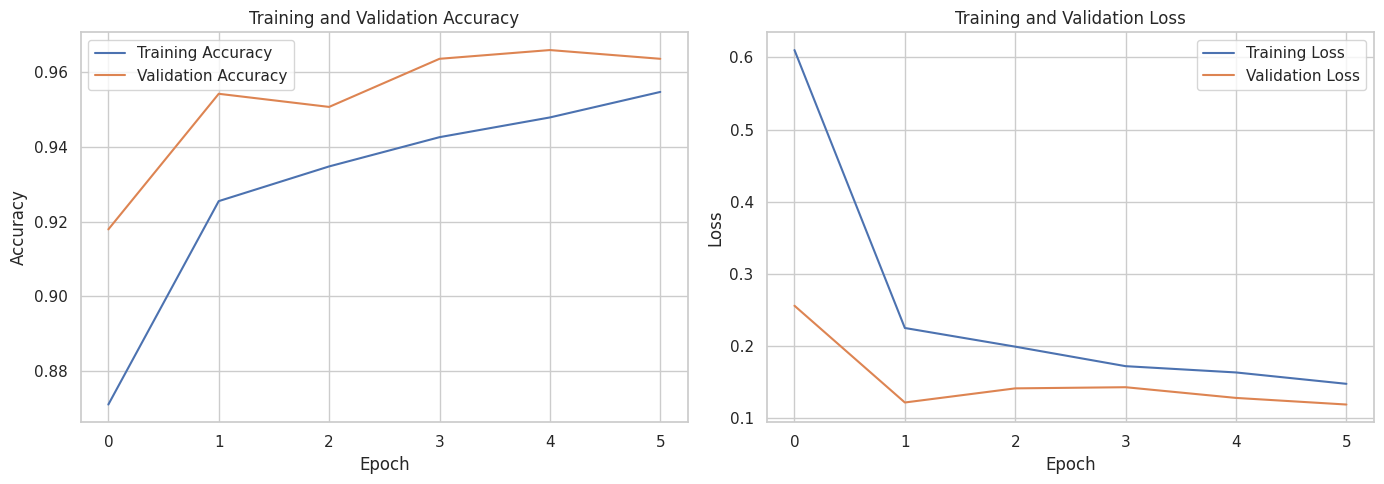

In [32]:
# Mengambil data dari history
history_val = history.history

# Plot akurasi Validation Dataset
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_val['accuracy'], label='Training Accuracy')
plt.plot(history_val['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot (loss) untuk Validation Dataset
plt.subplot(1, 2, 2)
plt.plot(history_val['loss'], label='Training Loss')
plt.plot(history_val['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [33]:
# Menyimpan model dalam format SavedModel
save_path = 'saved_model/model_sampah'
model.export(save_path)

print(f"Model berhasil diekspor dalam format SavedModel di: {save_path}")


Saved artifact at 'saved_model/model_sampah'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137702393649808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393650384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393653840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393653456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393652496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393654032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393653072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393650000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393654224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137702393652112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13

In [34]:
# Mengonversi model ke TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

# Menyimpan file .tflite
tflite_save_path = 'saved_model/model_sampah.tflite'
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model TFLite berhasil disimpan di: {tflite_save_path}")

Model TFLite berhasil disimpan di: saved_model/model_sampah.tflite


In [35]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [36]:
# Mengonversi model ke TensorFlow.js
import tensorflowjs as tfjs

tfjs_save_path = 'saved_model/model_sampah_tfjs'
tfjs.converters.save_keras_model(model, tfjs_save_path)

print(f"Model TFJS berhasil disimpan di: {tfjs_save_path}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS berhasil disimpan di: saved_model/model_sampah_tfjs


## Inference (Optional)

In [37]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='saved_model/model_sampah.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get input shape
input_shape = input_details[0]['shape']

# Fungsi untuk preprocessing gambar
def preprocess_image(img_path, target_size):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [42]:
# --- Upload gambar ---
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

Saving Kain-majun.jpg to Kain-majun.jpg


Raw Output: [[9.8493123e-01 3.3658903e-04 1.4347812e-02 2.6514661e-04 1.1915303e-04]]
Predicted Class: fabric-product


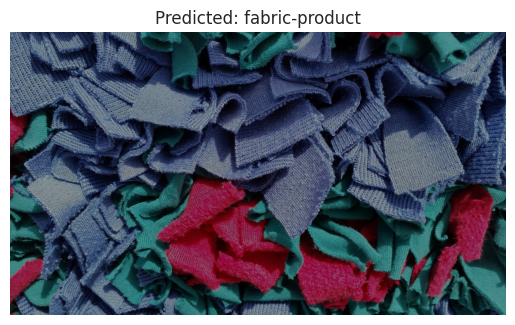

In [43]:
# --- Preprocess gambar ---
input_data = preprocess_image(img_path, target_size=(input_shape[1], input_shape[2]))

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Raw Output:", output_data)

# Daftar nama kelas
class_names = [
    "fabric-product",
    "glass-material",
    "non-recyclable",
    "paper-material",
    "recyclable-inorganic"
]

# Get predicted class
predicted_class = np.argmax(output_data, axis=1)
predicted_class_name = class_names[predicted_class[0]]

print(f"Predicted Class: {predicted_class_name}")

# --- Tampilkan gambar ---
img_display = Image.open(img_path)
plt.imshow(img_display)
plt.title(f"Predicted: {predicted_class_name}")
plt.axis('off')
plt.show()